In [1]:
import numpy as np
import cv2
from kernel import kernel
import random
import argparse
import imageio
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

In [48]:
colormap=[[255,0,0],[0,0,255],[0,255,0],[255,255,0]]
n_cluster=int(input('number of cluster: '))
img_name=input('Image name: ')
method=input('Method: ')
init_method=input('Initial method ( random or kmeans++ ): ')
n_points=10000
img=cv2.imread(img_name+'.png')
img=img.reshape(n_points,3)
if method!='normalized' and method!='ratio':
    print('unknown method')

In [4]:
def draw(cluster):
    color=np.zeros((n_points,3),dtype=np.uint8)
    for i in range(n_points):
        color[i]=colormap[cluster[i]]
    color=color.reshape(100,100,3)    
    return color

In [5]:
def init(X,init_method='random'):
    mean =	np.random.rand(n_cluster, n_cluster)
    cluster = np.random.randint(0, n_cluster, n_points)
    
    if init_method=='random':
        for i in range(n_cluster):
            idx=np.random.randint(0,n_points-1)
            mean[:,i]=X[idx]
        return cluster,mean

    elif init_method=='kmeans++':
        mean[:,0]=X[np.random.randint(0,n_points-1),:]
        for i in range(1,n_cluster):
            distance=cdist(X,mean[:,i-1].reshape(1,-1)).min(axis=1)
            p=distance/np.sum(distance)
            mean[:,i]=X[np.random.choice(range(n_points),p=p)]
        return cluster,mean

    else:
        print('Unknown methd') 

In [10]:
def kmeans(X,k):
    #init
    cluster,mean=init(X,init_method)

    distance=np.zeros(k)
    delta=100
    iter=0
    gif_buff=[]
    while delta!=0:
        pre_cluster=cluster.copy()
        iter+=1
        print('Iter: ',iter)
        for i in range(n_points):
            for j in range(k):
                distance[j]=np.sum((X[i]-mean[j])**2)
            cluster[i]=np.argmin(distance)

        mean=np.zeros((k,k))
        cnt=np.zeros(k)
        for i in range(n_points):
            mean[cluster[i]]+=X[i]
            cnt[cluster[i]]+=1
        for i in range(k):
            mean[i]/=cnt[i]
        
        gif_buff.append(draw(cluster))

        delta=np.sum(np.absolute(cluster-pre_cluster))
        print('Delta: ',delta)
        print('-------------------------------------')

    imageio.mimsave('spectral_'+str(n_cluster)+'_'+method+'_'+init_method+'_'+img_name+'.gif',gif_buff,'GIF',duration=0.1)
    return cluster   

In [11]:
def draw_eigensapce(T,cluster):
    x=[[],[]]
    y=[[],[]]
    color=['red','blue']
    for i in range(n_points):
        x[cluster[i]].append(T[i][0])
        y[cluster[i]].append(T[i][1])
    for i in range(n_cluster):
        plt.scatter(x[i],y[i],c=color[i])
    plt.show()

Normalize Laplacian<br>
L=D^-1/2@L@D^-1/2=I-D^-1/2@W@D-1/2

In [49]:
W = kernel(img)
D = np.sum(W, axis=1)

if method=='normalized':
    D_sqr = np.power(D, -0.5)*np.identity(n_points)
    L=np.identity(n_points)-D_sqr@W@D_sqr
    eigen_val, eigen_vec = np.linalg.eig(L)
    idx = np.argsort(eigen_val)
    eigen_vec = eigen_vec[:, idx]
    U = eigen_vec[:, 1:n_cluster+1].real
    norm_T=np.zeros(U.shape)
    for i in range(n_points):
        norm_T[i]=U[i]/np.sqrt(np.sum(U[i]**2))
elif method=='ratio':
    L=D-W
    eigen_val, eigen_vec = np.linalg.eig(L)
    idx = np.argsort(eigen_val)
    eigen_vec = eigen_vec[:, idx]
    ratio_T = eigen_vec[:, 1:n_cluster+1].real
else:
    print('Unknown method')

In [50]:
if method=='normalized':
    cluster=kmeans(norm_T,n_cluster)
elif method=='ratio':
    cluster=kmeans(ratio_T,n_cluster)

Iter:  1
Delta:  4967
-------------------------------------
Iter:  2
Delta:  2139
-------------------------------------
Iter:  3
Delta:  919
-------------------------------------
Iter:  4
Delta:  290
-------------------------------------
Iter:  5
Delta:  231
-------------------------------------
Iter:  6
Delta:  210
-------------------------------------
Iter:  7
Delta:  182
-------------------------------------
Iter:  8
Delta:  143
-------------------------------------
Iter:  9
Delta:  128
-------------------------------------
Iter:  10
Delta:  85
-------------------------------------
Iter:  11
Delta:  58
-------------------------------------
Iter:  12
Delta:  40
-------------------------------------
Iter:  13
Delta:  26
-------------------------------------
Iter:  14
Delta:  16
-------------------------------------
Iter:  15
Delta:  10
-------------------------------------
Iter:  16
Delta:  6
-------------------------------------
Iter:  17
Delta:  4
-----------------------------------

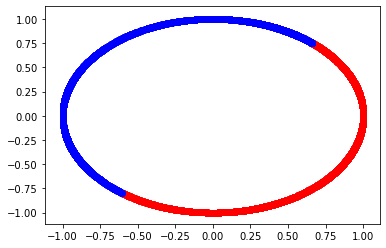

In [39]:
draw_eigensapce(norm_T,cluster)